Husni Fadhilah Dhiya Ul Haq

23523034

UTS IF5281 DEEP LEARNING

In [1]:
import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
!pip install git+https://github.com/RobustBench/robustbench.git
!git clone https://github.com/kentaroy47/vision-transformers-cifar10.git

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-r5j330by
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-r5j330by
  Resolved https://github.com/RobustBench/robustbench.git to commit 78fcc9e48a07a861268f295a777b975f25155964
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /tmp/pip-install-6eo39bij/autoattack_4d054dedfdcb4c17ac4f2ad1b8a1f50e
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /tmp/pip-install-6eo39bij/autoattack_4d054dedfdcb4c17ac4f2ad1b8a1f50e
  Running command git rev-parse -q --verify 'sha^a39220048b3c9f2cca9a4d3a54604793c68eca7e'
  Running command git fetch -q https://github.com/fra31/auto-attack.git a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Resolved https://github.com/fra31/auto-attack.git to commit a39220048b3c9f2cca9a4

In [3]:
# Constants
# EPOCHS = 50
# LR = 0.01
# NUM_CLASSES = 100
# BATCH_SIZE = 64
# IMG_SIZE = 224
EPOCHS = 25
LR = 1e-4
NUM_CLASSES = 100
BATCH_SIZE = 32
IMG_SIZE = 224
size = 224
patch = 4
dimhead = 512
convkernel = 8
ROOT_DATA = '/kaggle/input/imagenet100/ImageNet100'
ImageNet_CORRUPT_PATH = '/kaggle/input/natural-adversarial-examples-imageneta/imagenet-a/imagenet-a'

corruption_types = ['jpeg_compression', 'defocus_blur', 'frost', 
                    'zoom_blur', 'snow', 'glass_blur', 'fog', 'elastic_transform', 
                    'contrast', 'shot_noise', 'pixelate', 'impulse_noise', 'motion_blur', 
                    'gaussian_noise', 'brightness']
# corruption_types = [
#     'brightness', 'contrast', 'defocus_blur', 'elastic_transform',
#     'fog', 'frost', 'gaussian_blur', 'gaussian_noise',
#     'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur',
#     'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter',
#     'speckle_noise', 'zoom_blur'
# ]

In [4]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TrF
import argparse, math, os, random, sys, torch, torchvision, time, timm
from PIL import Image
from collections import OrderedDict
from robustbench.data import load_cifar10c, load_imagenetc
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset, Dataset, DataLoader, SubsetRandomSampler

import sys
sys.path.append('/kaggle/working/vision-transformers-cifar10')
from models import *

# Read & Plot Data

1. Implementasi Data/Image Preprocessing

Dataset CIFAR-10 merupakan dataset yang dibentuk oleh tim riset University of Toronto https://www.cs.toronto.edu/~kriz/cifar.html, terdiri dari 60,000 gambar RGB (50,000 train dan 10,000 test) berdimensi 32x32. CIFAR-10 memiliki 10 kelas / kategori objek: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

a. Tipe data yang digunakan

Array numpy yang berisi data gambar mentah yang jika dilihat berukuran 32x32, selanjutnya dilakukan preprocessing sehingga didapatkan:

trainloader, testloader

b. Pra-pemrosesan data yang dilakukan

Dataset yang diload dari PyTorch secara langsung lalu diolah dan ditransformasi. Transformasi yang didefinisikan meliputi proses seperti pemangkasan acak (random crop) dengan padding 4 piksel, flipping horizontal secara acak, dan mengubah data menjadi tensor (untuk data train dan testing). Ukuran batch pada train yaitu 128, serta 100 pada data testing. Data train dilakukan shuffle, sedangkan data testing tidak

In [5]:
class RandomImageTransform(object):
    def __init__(self, impulse_prob=0.1, gauss_prob=0.1, contrast_prob=0.1, fog_prob=0.1, noise_prob=0.01, amplitude=10000, noise_std=0.05, contrast_range=(0.5, 1.5), fog_density=0.5):
        self.impulse_prob = impulse_prob
        self.gauss_prob = gauss_prob
        self.contrast_prob = contrast_prob
        self.fog_prob = fog_prob
        self.noise_prob = noise_prob
        self.amplitude = amplitude
        self.noise_std = noise_std
        self.contrast_range = contrast_range
        self.fog_density = fog_density

    def __call__(self, img):
        transform_prob = random.random()
        if transform_prob < self.contrast_prob:
            img = self.apply_contrast(img)
        elif transform_prob < self.contrast_prob + self.gauss_prob:
            img = self.apply_gaussian_noise(img)
        elif transform_prob < self.contrast_prob + self.gauss_prob + self.impulse_prob:
            img = self.apply_impulse_noise(img)
#         elif transform_prob < self.contrast_prob + self.gauss_prob + self.impulse_prob + self.fog_prob:
#             img = self.apply_fog(img)
        return img

    def apply_impulse_noise(self, img):
        noise_mask = torch.rand_like(img)
        salt = (noise_mask < self.noise_prob / 2).float()
        pepper = (noise_mask > 1 - self.noise_prob / 2).float()

        noisy_img = img.clone()
        noisy_img += salt * 255.0 * 2 * self.amplitude
        noisy_img -= pepper * 255.0 * 2 * self.amplitude
        noisy_img = torch.clamp(noisy_img, 0, 255)
        return noisy_img

    def apply_gaussian_noise(self, img):
        noise = torch.randn_like(img) * self.noise_std
        noisy_img = img + noise
        noisy_img = torch.clamp(noisy_img, 0, 1)
        return noisy_img

    def apply_contrast(self, img):
        factor = random.uniform(*self.contrast_range)
        mean = torch.mean(img)
        img = (img - mean) * factor + mean
        img = torch.clamp(img, 0, 255)
        return img
    
    def apply_fog(self, img):
        fog_density = torch.randn_like(img) * self.noise_std + self.fog_density
        fog_density = torch.clamp(fog_density, 0, 1)  # Ensure values are between 0 and 1

        # Add fog to the image
        img = img * (1 - fog_density) + fog_density
        img = torch.clamp(img, 0, 1)  # Ensure values are between 0 and 1
        return img

In [6]:
# Melakukan pembacaan data dari sumber, serta melakukan preprocessing
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    RandomImageTransform(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torch.utils.data import SubsetRandomSampler
import numpy as np
import os

# trainset = ImageFolder(root=os.path.join(ROOT_DATA, 'train'), transform=transform_train)
# testset = ImageFolder(root=os.path.join(ROOT_DATA, 'val'), transform=transform_test)

# sample_percent = 0.001
# np.random.seed(42)

# train_indices = np.random.choice(len(trainset), int(sample_percent * len(trainset_full)), replace=False)
# test_indices = np.random.choice(len(testset), int(sample_percent * len(testset_full)), replace=False)

# train_sampler = SubsetRandomSampler(train_indices)
# test_sampler = SubsetRandomSampler(test_indices)

# trainloader = DataLoader(trainset_full, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=4, pin_memory=True, drop_last=True)
# testloader = DataLoader(testset_full, batch_size=BATCH_SIZE, sampler=test_sampler, num_workers=4, pin_memory=True, drop_last=True)

# classes = trainset.dataset.classes


trainset = ImageFolder(root=f'{ROOT_DATA}/train', transform=transform_train)
testset = ImageFolder(root=f'{ROOT_DATA}/val', transform=transform_test)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

classes = trainset.classes

==> Preparing data..


In [7]:
print("Train batch set size:", len(trainloader))
print("Test batch set size:", len(testloader))
print("Train set size:", len(trainloader.dataset))
print("Test set size:", len(testloader.dataset))

Train batch set size: 3959
Test batch set size: 156
Train set size: 126689
Test set size: 5000


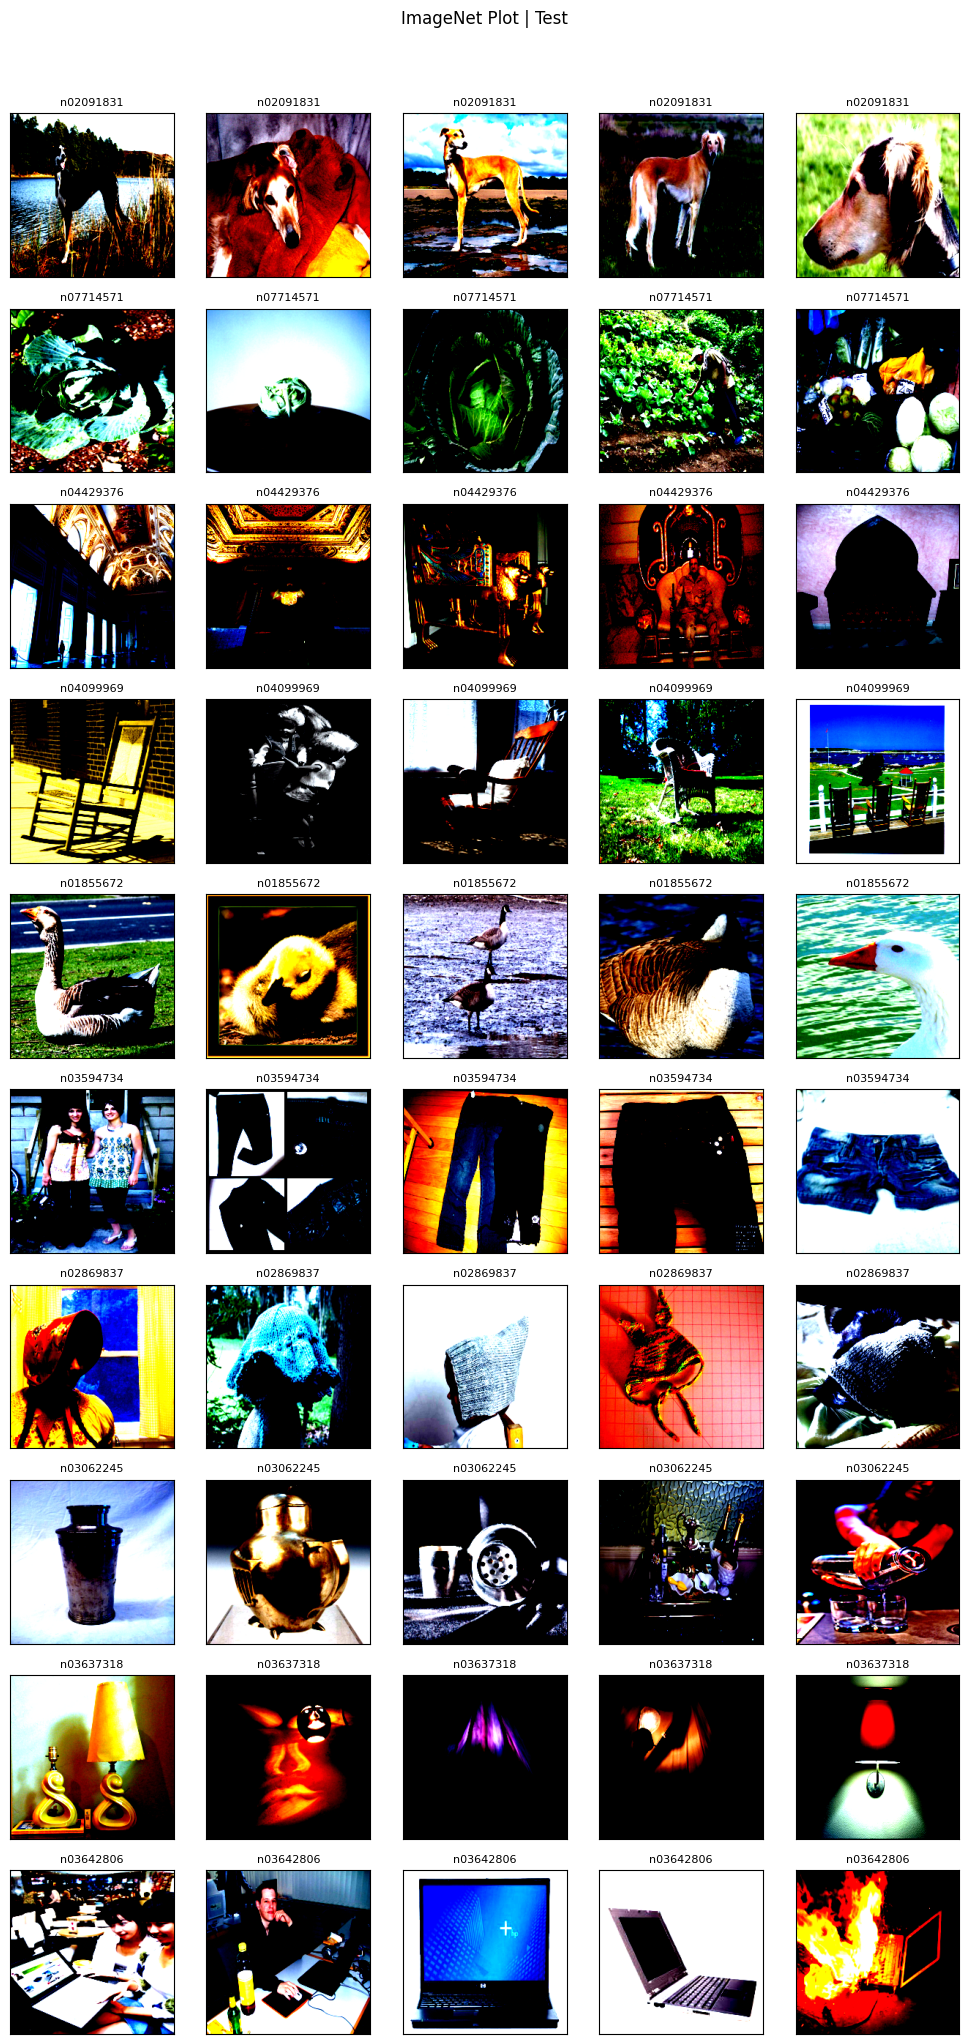

In [8]:
# Plot gambar per kelas
def plot_ImageNet(ImageNet_dataset, data_title, num_images_per_class=5, max_classes=10):
    # classes = ImageNet_dataset.classes
    selected_classes = random.sample(classes, k=min(max_classes, len(classes)))
    class_indices = {class_name: [] for class_name in selected_classes}
    
    for i, (_, label) in enumerate(ImageNet_dataset):
        class_name = classes[label]
        if class_name in selected_classes and len(class_indices[class_name]) < num_images_per_class:
            class_indices[class_name].append(i)
        if all(len(indices) == num_images_per_class for indices in class_indices.values()):
            break

    fig, axes = plt.subplots(nrows=len(class_indices), ncols=num_images_per_class, figsize=(num_images_per_class*2, len(class_indices)*2))

    for i, class_name in enumerate(selected_classes):
        for j in range(num_images_per_class):
            index = class_indices[class_name][j]
            image, _ = ImageNet_dataset[index]
            axes[i, j].imshow(image.permute(1, 2, 0))
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].set_title(class_name, fontsize=8)

    plt.suptitle(f'ImageNet Plot | {data_title}', y=1.02)
    plt.tight_layout()
    plt.savefig(f'ImageNet_Plot_{data_title.lower()}.png')
    plt.show()
    
# plot_ImageNet(trainloader.dataset,'Train')
plot_ImageNet(testloader.dataset,'Test')

# Pembangunan Arsitektur Model

2. Implementasi Arsitektur Pelatihan Model

Metode ini membangun jaringan saraf konvolusional menggunakan ResNet34 dari library torchvision sebagai backbone model. Menggunakan solusi berbasis transfer learning di mana model yang telah dilatih pada tugas tertentu (biasanya tugas besar) digunakan sebagai titik awal untuk melatih model pada tugas serupa yang berbeda. Digunakan model ResNet34 yang telah dilatih pada dataset besar sebagai titik awal untuk tugas pengenalan kelas gambar yang lebih khusus. Arsitektur ResNet34 yang digunakan ada di bagian bawah markdown ini.

Model ResNet-34 memiliki lapisan fully connected di bagian akhir yang biasanya digunakan untuk menghubungkan representasi fitur dari lapisan konvolusi ke kelas target. Dalam fungsi ini, lapisan fully connected ini diganti dengan lapisan baru menggunakan torch.nn.Linear(model.fc.in_features, NUM_CLASSES), di mana NUM_CLASSES adalah jumlah kelas dalam dataset target. Bobot lapisan fully connected yang baru digunakan diinisialisasi dengan bobot dari ImageNet. Model ini dikompilasi menggunakan categorical crossentropy loss, optimizer SGD dengan momentum, dan akurasi sebagai metriknya. Berikut penjelasan tentang arsitektur umum yang digunakan.

Disusun model ResNet34, yang telah diinisialisasi dengan bobot dari ImageNet. Selanjutnya menggunakan SGD sebagai salah satu optimizer yang paling umum digunakan dalam pelatihan model jaringan saraf tiruan. Argumen net.parameters() digunakan untuk memberikan parameter yang akan dioptimalkan, yaitu parameter-parameter dari model. lr adalah laju pembelajaran (learning rate) yang menentukan seberapa besar langkah yang diambil pada setiap iterasi pelatihan. momentum mengontrol seberapa besar kontribusi momentum pada pembaruan parameter, sementara weight_decay adalah parameter yang mengatur kecepatan peluruhan bobot selama pelatihan untuk mencegah overfitting. 

CosineAnnealingLR Scheduler merupakan metode penjadwalan learning rate yang menggunakan penurunan kosinus. Dalam penurunan kosinus, learning raten diperbarui berdasarkan fungsi kosinus dari epoch, yang berarti learning rate secara bertahap menurun hingga mendekati nol. Argumen T_max menentukan jumlah epoch maksimum, yang biasanya diatur sama dengan jumlah epoch total pelatihan. Hal ini menunjukkan bahwa penurunan learning rate akan terjadi secara periodik selama jumlah epoch tersebut.

Sumber: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html

In [9]:
# !pip install pretrainedmodels

In [10]:
# import pretrainedmodels
# import ssl
# from timm import create_model

In [11]:
# def custom_model():
#     # Define the resnet model
# #     ssl._create_default_https_context = ssl._create_unverified_context
# #     model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
#     model = torchvision.models.vgg16(weights='IMAGENET1K_V1')
# #     model = torchvision.models.efficientnetb0(weights='IMAGENET1K_V1')
    
# #     for param in model.parameters():
# #         param.requires_grad = False
    
#     # Update the fully connected layer of resnet with our current target of 10 desired outputs
#     model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

# #     model = create_model('efficientnet_b0', pretrained=True)
# #     for param in model.parameters():
# #         param.requires_grad = False
#     # Make the parameters of certain layers trainable
# #     for name, param in model.named_parameters():
# #         if 'classifier' in name:  # Modify this condition as per your requirement
# #             param.requires_grad = True  # Unfreeze the parameters of the classifier layer
# #     model.classifier = nn.Linear(model.classifier.in_features, NUM_CLASSES)

# #     model = pretrainedmodels.__dict__["inceptionresnetv2"](pretrained='imagenet')
# #     model.last_linear = nn.Linear(model.last_linear.in_features, NUM_CLASSES)
    
#     return model

In [12]:
def custom_model(model_name='resnet34'):
    if model_name == 'resnet18':
        model = torchvision.models.resnet18(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'resnet34':
        model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'resnet50':    
        model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'resnet101':
        model = torchvision.models.resnet101(weights='IMAGENET1K_V1')
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'resnet152':
        model = torchvision.models.resnet152(weights='IMAGENET1K_V1')
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'wide_resnet50_2':
        model = torchvision.models.wide_resnet50_2(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'wide_resnet101_2':
        model = torchvision.models.wide_resnet101_2(weights='IMAGENET1K_V1')
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'mnasnet1_0':
        model = torchvision.models.mnasnet1_0(pretrained=True)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'alexnet':
        model = torchvision.models.alexnet(pretrained=True)
        model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
    elif model_name == 'googlenet':
        model = torchvision.models.googlenet(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'vgg16':
        model = torchvision.models.vgg16(pretrained=True)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = torch.nn.Linear(num_ftrs, NUM_CLASSES)
    elif model_name == 'inception_v3':
        model = torchvision.models.inception_v3(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'mobilenetv2':
        model = torchvision.models.mobilenet_v2(pretrained=True)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'mobilenetv3_small':
        model = torchvision.models.mobilenet_v3_small(pretrained=True)
        print(model.classifier)
        model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, NUM_CLASSES)
    elif model_name == 'mobilenetv3_large':
        model = torchvision.models.mobilenet_v3_large(pretrained=True)
        model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, NUM_CLASSES)
    elif model_name == 'densenet121':
        model = torchvision.models.densenet121(pretrained=True)
        model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
    elif model_name == 'densenet161':
        model = torchvision.models.densenet161(pretrained=True)
        model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
    elif model_name == 'densenet169':
        model = torchvision.models.densenet169(weights='IMAGENET1K_V1')
        model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
    elif model_name == 'densenet201':
        model = torchvision.models.densenet201(weights='IMAGENET1K_V1')
        model.classifier = torch.nn.Linear(model.classifier.in_features, NUM_CLASSES)
    elif model_name == 'squeezenet1_0':
        model = torchvision.models.squeezenet1_0(pretrained=True)
        model.classifier[1] = torch.nn.Conv2d(512, NUM_CLASSES, kernel_size=(1,1), stride=(1,1))
    elif model_name == 'squeezenet1_1':
        model = torchvision.models.squeezenet1_1(pretrained=True)
        model.classifier[1] = torch.nn.Conv2d(512, NUM_CLASSES, kernel_size=(1,1), stride=(1,1))
    elif model_name == 'resnext50_32x4d':
        model = torchvision.models.resnext50_32x4d(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'shufflenet_v2_x1_0':
        model = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif model_name == 'vit_b_16':
        model = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, NUM_CLASSES)
    elif model_name == 'vit_b_32':
        model = torchvision.models.vit_b_32(weights='IMAGENET1K_V1')
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, NUM_CLASSES)
    elif model_name == 'vit_h_14':
        model = torchvision.models.vit_h_14()
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, NUM_CLASSES)
    elif model_name == 'vit_l_16':
        model = torchvision.models.vit_l_16(weights='IMAGENET1K_V1')
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, NUM_CLASSES)
    elif model_name == 'vit_l_32':
        model = torchvision.models.vit_l_32(weights='IMAGENET1K_V1')
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, NUM_CLASSES)
    elif model_name == "vit_timm":
        model = timm.create_model("vit_small_patch16_224", pretrained=True)
        model.head = nn.Linear(model.head.in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b0':
        model = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b1':
        model = torchvision.models.efficientnet_b1(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b2':
        model = torchvision.models.efficientnet_b2(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b3':
        model = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b4':
        model = torchvision.models.efficientnet_b4(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b5':
        model = torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b6':
        model = torchvision.models.efficientnet_b6(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif model_name == 'efficientnet_b7':
        model = torchvision.models.efficientnet_b7(weights='IMAGENET1K_V1')
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    else:
        raise ValueError("Invalid model name! Supported models: vgg, inception, mobilenet, densenet, squeezenet, resnext, nasnet, xception, shufflenet")
    
    return model

In [13]:
# !pip install einops

# import torch.nn.functional as F
# from typing import Callable
# from einops import rearrange, reduce, repeat

# class ConvTokenizer(nn.Module):
#     def __init__(
#         self,
#         channels: int = 3, emb_dim: int = 256,
#         conv_kernel: int = 3, conv_stride: int = 2, conv_pad: int = 3,
#         pool_kernel: int = 3, pool_stride: int = 2, pool_pad: int = 1,
#         activation: Callable = nn.ReLU
#     ):
#         super().__init__()
#         self.conv = nn.Conv2d(
#             in_channels=channels, out_channels=emb_dim,
#             kernel_size=conv_kernel, stride=conv_stride,
#             padding=(conv_pad, conv_pad)
#         )
#         self.act = activation(inplace=True)
#         self.max_pool = nn.MaxPool2d(
#             kernel_size=pool_kernel, stride=pool_stride, 
#             padding=pool_pad
#         )
            
#     def forward(self, x: torch.Tensor):
#         x = self.conv(x)
#         x = self.act(x)
#         x = self.max_pool(x)
#         return x

In [14]:
# class TransformerEncoderBlock(nn.Module):
#     """Transformer Encoder Block"""

#     def __init__(
#         self, n_h: int, emb_dim: int, feat_dim: int, 
#         dropout: float = 0, attention_dropout: float = 0
#     ):
#         super().__init__()
#         self.msa = MSA(heads=n_h, emb_dim=emb_dim, dropout=dropout, attention_dropout=attention_dropout)
#         self.norm1 = nn.LayerNorm(emb_dim)
#         self.ffn = MLP(emb_dim, feat_dim, dropout)
#         self.norm2 = nn.LayerNorm(emb_dim)

#     def forward(self, x: torch.Tensor):
#         identity = x
#         x = self.msa(x)
#         x += identity
#         x = self.norm1(x)
#         identity = x
#         x = self.ffn(x)
#         x += identity
#         x = self.norm2(x)
#         return x

In [15]:
# class MSA(nn.Module):
#     """Multi-head Self Attention Block"""

#     def __init__(
#         self, heads: int, emb_dim: int, 
#         dropout: float = 0., attention_dropout: float = 0.
#     ):
#         super().__init__()
#         self.emb_dim = emb_dim
#         self.n_h = heads
#         self.head_dim = self.emb_dim // self.n_h
#         self.q = nn.Linear(self.emb_dim, self.emb_dim)
#         self.k = nn.Linear(self.emb_dim, self.emb_dim)
#         self.v = nn.Linear(self.emb_dim, self.emb_dim)
#         self.attention_dropout = nn.Dropout(attention_dropout)
#         self.linear_projection = nn.Linear(self.emb_dim, self.emb_dim)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x: torch.Tensor):
#         # (bs,     s_l,      e_d)
#         batch_s, seq_len, emb_dim = x.shape
#         # (bs, s_l, e_d) -> (bs, s_l, n_h, h_d) -> (bs, n_h, s_l, h_d)
#         x_q = self.q(x).view(
#             batch_s, seq_len, self.n_h, self.head_dim).transpose(1, 2)
#         x_k = self.k(x).view(
#             batch_s, seq_len, self.n_h, self.head_dim).transpose(1, 2)
#         x_v = self.v(x).view(
#             batch_s, seq_len, self.n_h, self.head_dim).transpose(1, 2)
#         # @ operator is the convention for matrix multiplication, throughout python
#         # q @ k.T -> (bs, n_h, s_l, h_d) @ (bs, n_h, h_d, s_l) -> (bs, n_h, s_l, s_l)
#         # Softmax((q @ k.T)/root(h_d)) @ v
#         #   -> (bs, n_h, s_l, s_l) @ (bs, n_h, s_l, h_d) -> (bs, n_h, s_l, h_d)
#         attention = (x_q @ x_k.transpose(-2, -1)) / math.sqrt(x_q.size(-1))
#         attention = F.softmax(attention, dim=-1)
#         attention = self.attention_dropout(attention)
#         # (bs, n_h, s_l, h_d) -> (bs, s_l, n_h, h_d) -> (bs, s_l, e_d)
#         x = (attention @ x_v).transpose(1, 2).reshape(batch_s, seq_len, emb_dim)
#         x = self.linear_projection(x)
#         x = self.dropout(x)
#         return x

In [16]:
# class MLP(nn.Module):
#     """MLP block"""

#     def __init__(self, emb_dim: int, feat_dim: int, dropout: float = 0):
#         super().__init__()
#         self.layer1 = nn.Linear(emb_dim, feat_dim)
#         self.activation = nn.GELU()
#         self.dropout = nn.Dropout(dropout)
#         self.layer2 = nn.Linear(feat_dim, emb_dim)

#         # below init from torchvision
#         nn.init.xavier_uniform_(self.layer1.weight)
#         nn.init.xavier_uniform_(self.layer2.weight)
#         nn.init.normal_(self.layer1.bias, std=1e-6)
#         nn.init.normal_(self.layer2.bias, std=1e-6)

#     def forward(self, x: torch.Tensor):
#         x = self.layer1(x)
#         x = self.activation(x)
#         x = self.dropout(x)
#         x = self.layer2(x)
#         x = self.dropout(x)
#         return x

In [17]:
# class SeqPool(nn.Module):
#     def __init__(self, emb_dim=256):
#         super().__init__()
#         self.dense = nn.Linear(emb_dim, 1)
#         self.softmax = nn.Softmax(dim=-1)

#     def forward(self, x):
#         bs, seq_len, emb_dim = x.shape
#         identity = x
#         x = self.dense(x)
#         x = rearrange(
#             x, 'bs seq_len 1 -> bs 1 seq_len', seq_len=seq_len
#         )
#         x = self.softmax(x)
#         x = x @ identity
#         x = rearrange(
#             x, 'bs 1 e_d -> bs e_d', e_d=emb_dim
#         )
#         return x

In [18]:
# class CCT(nn.Module):
#     """
#         Compact Convolutional Transformer (CCT) Model
#         https://arxiv.org/abs/2104.05704v4
#     """    
#     def __init__(
#         self,
#         conv_kernel: int = 3, conv_stride: int = 2, conv_pad: int = 3,
#         pool_kernel: int = 3, pool_stride: int = 2, pool_pad: int = 1,
#         heads: int = 4, emb_dim: int = 256, feat_dim: int = 2*256, 
#         dropout: float = 0.1, attention_dropout: float = 0.1, layers: int = 7, 
#         channels: int = 3, image_size: int = 32, num_class: int = 10
#     ):
#         super().__init__()
#         self.emb_dim = emb_dim
#         self.image_size = image_size

#         self.tokenizer = ConvTokenizer(
#             channels=channels, emb_dim=self.emb_dim,
#             conv_kernel=conv_kernel, conv_stride=conv_stride, conv_pad=conv_pad,
#             pool_kernel=pool_kernel, pool_stride=pool_stride, pool_pad=pool_pad,
#             activation=nn.ReLU
#         )

#         with torch.no_grad():
#             x = torch.randn([1, channels, image_size, image_size])
#             out = self.tokenizer(x)
#             _, _, ph_c, pw_c  = out.shape

#         self.linear_projection = nn.Linear(
#             ph_c, pw_c, self.emb_dim
#         )

#         self.pos_emb = nn.Parameter(
#             torch.randn(
#                 [1, ph_c*pw_c, self.emb_dim]
#             ).normal_(std=0.02) # from torchvision, which takes this from BERT
#         )
#         self.dropout = nn.Dropout(dropout)
#         encoders = []
#         for _ in range(0, layers):
#             encoders.append(
#                 TransformerEncoderBlock(
#                     n_h=heads, emb_dim=self.emb_dim, feat_dim=feat_dim,
#                     dropout=dropout, attention_dropout=attention_dropout
#                 )
#             )
#         self.encoder_stack = nn.Sequential(*encoders)
#         self.seq_pool = SeqPool(emb_dim=self.emb_dim)
#         self.mlp_head = nn.Linear(self.emb_dim, num_class)


#     def forward(self, x: torch.Tensor):     
#         bs, c, h, w = x.shape  # (bs, c, h, w)

#         # Creates overlapping patches using ConvNet
#         x = self.tokenizer(x)
#         x = rearrange(
#             x, 'bs e_d ph_h ph_w -> bs (ph_h ph_w) e_d', 
#             bs=bs, e_d=self.emb_dim
#         )

#         # Add position embedding
#         x = self.pos_emb.expand(bs, -1, -1) + x
#         x = self.dropout(x)

#         # Pass through Transformer Encoder layers
#         x = self.encoder_stack(x)

#         # Perform Sequential Pooling <- Novelty of the paper
#         x = self.seq_pool(x)

#         # MLP head used to get logits
#         x = self.mlp_head(x)

#         return x

In [19]:
# def custom_model():
#     config = dict(
#         seed=42, # <-- the answer to life, the universe and everything
#         heads=4, emb_dim=256, feat_dim=512, layers=7,
#         num_class=NUM_CLASSES, image_size=IMG_SIZE,
#         dropout=0.5, attention_dropout=0.1,
#     )
    
#     model = CCT(
#         heads=config['heads'], emb_dim=config['emb_dim'], 
#         feat_dim=config['feat_dim'], layers=config['layers'],
#         num_class=config['num_class'], image_size=config['image_size'], 
#         dropout=config['dropout'], attention_dropout=config['attention_dropout']
#     )
    
#     return model

In [20]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         # Convolutional layers
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         # Max pooling layers
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         # Fully connected layers
# #         self.fc1 = nn.Linear(128 * 4 * 4, 512)
#         self.fc1 = nn.Linear(128 * 8 * 8, 512)
#         self.fc2 = nn.Linear(512, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = x.view(-1, 128 * 4 * 4)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
    
# def custom_model():
#     return CNN()

Secara ringkas, optimizer SGD digunakan untuk mengoptimalkan parameter-parameter model dengan mengurangi fungsi kerugian (loss function) selama pelatihan. Momentum dan weight decay digunakan untuk membantu percepatan konvergensi dan mencegah overfitting. Sementara itu, penjadwalan laju pembelajaran dengan penurunan kosinus memastikan bahwa laju pembelajaran dikurangi secara bertahap selama pelatihan, sehingga memungkinkan model untuk menemukan minimum global secara lebih stabil.

In [21]:
net = custom_model('vit_timm')
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=LR)
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
n_epoch = EPOCHS
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epoch)

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

# Detail Arsitektur ResNet34

ResNet-34 adalah salah satu arsitektur jaringan saraf konvolusional (CNN) yang populer dan efektif untuk tugas klasifikasi gambar. Arsitektur ini memiliki struktur yang dalam dengan total 34 lapisan yang terdiri dari berbagai jenis lapisan seperti konvolusi, normalisasi batch, ReLU (Rectified Linear Unit), dan blok dasar (basic blocks)

* Conv2d: merupakan lapisan konvolusi dua dimensi yang digunakan untuk mengekstraksi fitur dari gambar. Setiap lapisan konvolusi memiliki sejumlah filter (dalam contoh ini, 64, 128, 256, dan 512 filter) yang diterapkan pada gambar input untuk menghasilkan fitur-fitur yang lebih abstrak (Goodfellow et al., 2016).

* BatchNorm2d: lapisan normalisasi batch digunakan untuk mempercepat pelatihan dan mengurangi overfitting dengan normalisasi output dari lapisan sebelumnya (Ioffe & Szegedy, 2015).

* ReLU: ReLU adalah fungsi aktivasi yang diterapkan setelah setiap operasi konvolusi atau normalisasi. ReLU membantu dalam mengenali fitur non-linear dalam data (Agarap, 2018).

* MaxPool2d: lapisan untuk mereduksi dimensi spasial dari fitur konvolusi. Ini membantu dalam mengurangi beban komputasi dan membuat representasi fitur lebih invarian terhadap translasi kecil dalam gambar (Gu et al., 2018).

* Sequential: merupakan wadah yang digunakan untuk mengelompokkan serangkaian lapisan menjadi satu unit yang dapat diterapkan pada input secara berurutan.

* BasicBlock: merupakan blok bangunan dasar dari ResNet yang terdiri dari dua lapisan konvolusi dengan normalisasi batch dan ReLU di antaranya. Blok ini juga bisa memiliki jalur pendek (skip connection) yang membantu dalam mengatasi masalah perubahan mendalam yang mungkin terjadi selama pelatihan.

* AdaptiveAvgPool2d: merupakan lapisan average pooling adaptif yang digunakan untuk mengubah ukuran representasi fitur menjadi ukuran tertentu sebelum dihubungkan ke lapisan fully connected.

* Linear: merupakan lapisan fully connected yang digunakan untuk menghubungkan representasi fitur yang telah diekstraksi dengan label kelas.

Referensi:

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

In [22]:
print(net)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

# Pelatihan Model

Dilakukan proses pelatihan dengan data latih bersumber dari trainloader, serta data validasi bersumber dari testloader. Pada setiap epoch, dipantau akurasi, loss, serta dicatat waktu pelatihannya. Kemudian dilakukan ploting terhadap loss dan akurasi selama fase pelatihan. 

Referensi kode dengan modifikasi:

https://www.kaggle.com/code/luckily66/gpipe-of-monocnn101

In [23]:
best_acc = 0
start_epoch = 0
c_type_errors = {}

# Model
print('==> Building model..')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Use CUDA' if torch.cuda.is_available() else 'Use CPU')

net = net.to(device)
train_accuracy_list, val_accuracy_list, train_loss_list, val_loss_list = [],[],[],[] 
# Training
def train(epoch):
    print('\nEpoch: {:d}  lr: {:.4f}'.format(epoch, scheduler.get_last_lr()[0]))
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward() 
        nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, net.parameters()), max_norm=5)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    # Calculate and print average loss and accuracy for the epoch
    avg_loss = train_loss / len(trainloader)
    accuracy = 100. * correct / total    
    train_accuracy_list.append(accuracy)
    train_loss_list.append(avg_loss)
    print('Train Loss: {:.3f} | Acc: {:.3f}% ({:d}/{:d})'.format(avg_loss, accuracy, correct, total))
    if torch.isnan(torch.tensor(avg_loss)):
        return True

    return False


def test(net, testloader, is_train = True):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    correct_sample_indices = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            # inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct_sample_indices.extend(predicted.eq(targets).cpu().detach().numpy().tolist())
            correct += predicted.eq(targets).sum().item()

            if total >= 10000:
                break
    accuracy = 100. * correct / total
    loss = test_loss / (batch_idx + 1)
    if(is_train):
        val_accuracy_list.append(accuracy)
        val_loss_list.append(loss)
    print('Test Loss: {:.3f} | Acc: {:.3f} ({:d}/{:d})'.format(loss, accuracy, correct, total))
    return accuracy, np.where(correct_sample_indices)[0]
     

save_data_dict = OrderedDict()
start_time = time.time()
for epoch in range(start_epoch, start_epoch+n_epoch):
    epoch_start_time = time.time()
    terminate = train(epoch)
    acc, sampler_indices = test(net, testloader)
    scheduler.step()
    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print(f'Time elapsed: %.2f s' % epoch_time)
    if epoch == start_epoch+n_epoch-1:
        c_type_errors['original'] = 1-acc/100
    if terminate:
        break

save_data_dict['acc'] = acc
save_data_dict['state_dict'] = net.state_dict()
end_time = time.time()
training_time = end_time - start_time
print('\nFinished Training\nTotal Training Time: %.2f seconds' % training_time)

==> Building model..
Use CUDA

Epoch: 0  lr: 0.0001
Train Loss: 1.833 | Acc: 62.343% (78981/126688)
Test Loss: 0.445 | Acc: 88.562 (4421/4992)
Time elapsed: 1305.26 s

Epoch: 1  lr: 0.0001
Train Loss: 0.730 | Acc: 83.146% (105336/126688)
Test Loss: 0.332 | Acc: 91.046 (4545/4992)
Time elapsed: 1344.32 s

Epoch: 2  lr: 0.0001
Train Loss: 0.661 | Acc: 84.575% (107147/126688)
Test Loss: 0.295 | Acc: 91.887 (4587/4992)
Time elapsed: 1315.07 s

Epoch: 3  lr: 0.0001
Train Loss: 0.615 | Acc: 85.637% (108492/126688)
Test Loss: 0.279 | Acc: 92.248 (4605/4992)
Time elapsed: 1314.62 s

Epoch: 4  lr: 0.0001
Train Loss: 0.600 | Acc: 86.034% (108995/126688)
Test Loss: 0.271 | Acc: 92.388 (4612/4992)
Time elapsed: 1314.53 s

Epoch: 5  lr: 0.0001
Train Loss: 0.575 | Acc: 86.559% (109660/126688)
Test Loss: 0.266 | Acc: 92.448 (4615/4992)
Time elapsed: 1313.44 s

Epoch: 6  lr: 0.0001
Train Loss: 0.562 | Acc: 86.968% (110178/126688)
Test Loss: 0.262 | Acc: 92.788 (4632/4992)
Time elapsed: 1313.84 s

Epoc

In [24]:
# Save model ke file
torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_acc': acc,
    'train_accuracy_list': train_accuracy_list,
    'val_accuracy_list': val_accuracy_list,
    'train_loss_list': train_loss_list,
    'val_loss_list': val_loss_list,
}, f'vit_timm_best_model.pth')

3. Visualisasi Progress Pelatihan

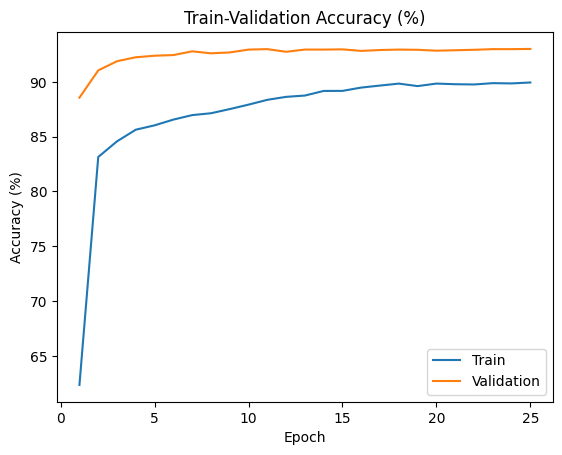

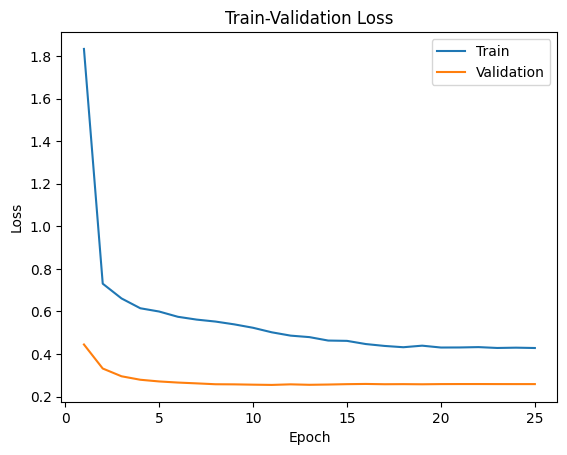

In [25]:
# Plot train and validation accuracy & loss
def plot_train_val(train_list, val_list, metric_type, EPOCHS):
    plt.plot(range(1, EPOCHS + 1), train_list, label='Train')
    plt.plot(range(1, EPOCHS + 1), val_list, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(metric_type)
    plt.title(f'Train-Validation {metric_type}')
    plt.legend()
    plt.savefig(f'train_val_{metric_type.lower()}.png')
    plt.show()

plot_train_val(train_accuracy_list, val_accuracy_list, 'Accuracy (%)', EPOCHS)
plot_train_val(train_loss_list, val_loss_list, 'Loss', EPOCHS)

# Pengujian dengan Dataset ImageNet-Corrupted

ImageNet-C merupakan dataset yang dibentuk oleh (Hendrycks and Dietterich, ICLR2019) untuk melakukan benchmarking kehandalan berbagai deep learning classifiers terhadap berbagai kerusakan atau noise pada gambar objek.

ImageNet-C berasal dari sampel uji ImageNet yang asli, lalu diberikan variasi dengan berbagai jenis kerusakan (corruption) dan tingkat severity. Terdapat 19 jenis keruasakan dan 5 tingkatan severity pada dataset ImageNet-C. Di sini digunakan data ImageNet-C yang diambil dari Kaggle, tetapi juga bersumber dari penelitian Hendrycks and Dietterich.

Jenis kerusakannya adalah sebagai berikut:

'brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur'

Selanjutnya dilakukan proses pengujian terhadap model yang telah dilatih sebelumnya. Pengujian menggunakan dataloader ImageNet-C untuk 19 kategori kerusakan dan dipantau loss serta akurasinya. Kemudian untuk semua jenis kerusakan tersebut, dilakukan ploting dan dihitung rata-rata error serta akurasinya.

In [26]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from PIL import Image
import os

class RealImageNetA(Dataset):
    def __init__(self, root, transform=None, class_to_idx=None):
        self.root = root
        self.transform = transform
        self.samples = []

        raw_dataset = ImageFolder(self.root)  # Hanya untuk membaca struktur folder
        for path, _ in raw_dataset.samples:
            class_name = os.path.basename(os.path.dirname(path))
            if class_to_idx and class_name in class_to_idx:
                label = class_to_idx[class_name]
                self.samples.append((path, label))
            else:
                continue  # Lewati kelas di luar label trainset

    def __getitem__(self, index):
        path, label = self.samples[index]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.samples)

# Ambil class-to-index dari trainset
imagenet_class_to_idx = trainset.class_to_idx

realtestset = RealImageNetA(
    root=ImageNet_CORRUPT_PATH,
    transform=transform_test,
    class_to_idx=imagenet_class_to_idx
)

realtestloader = torch.utils.data.DataLoader(
    realtestset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

In [27]:
print(len(realtestloader))
print(len(realtestloader.dataset))
used_class_indices = sorted(set([label for _, label in realtestloader.dataset.samples]))
idx_to_class = {v: k for k, v in trainset.class_to_idx.items()}
used_class_names = [idx_to_class[i] for i in used_class_indices]

print(f"Jumlah kelas aktif di realtest: {len(used_class_names)}")
print("Contoh kelas:", used_class_names[:10])

22
680
Jumlah kelas aktif di realtest: 15
Contoh kelas: ['n01558993', 'n01735189', 'n01820546', 'n01855672', 'n02085620', 'n02106550', 'n02119022', 'n02231487', 'n02259212', 'n02701002']


In [28]:
# plot_ImageNet(realtestloader.dataset,'Test Real World')

4. Penyajian/visualisasi hasil evaluasi (accuracy atau error) keseluruhan

In [29]:
acc_real, _ = test(net, realtestloader, is_train=False)
print(f"Real test accuracy (ImageNet-A): {acc_real:.2f}%")

Test Loss: 3.372 | Acc: 36.618 (249/680)
Real test accuracy (ImageNet-A): 36.62%


In [30]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, accuracy_score, top_k_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_metrics(model, dataloader, device, num_classes=800):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    # Global metrics
    acc1 = accuracy_score(y_true, y_pred)
    acc5 = top_k_accuracy_score(y_true, y_probs, k=5, labels=list(range(num_classes)))
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Top-1 Accuracy: {acc1:.4f}")
    print(f"Top-5 Accuracy: {acc5:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")

    return y_true, y_pred


def plot_confusion_subset(y_true, y_pred, class_names, top_n=10):
    # Hitung confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    
    # Ambil top_n kelas yang paling sering muncul di prediksi atau ground truth
    counts = np.bincount(y_true)
    top_classes_idx = np.argsort(counts)[::-1][:top_n]
    top_class_names = [class_names[i] for i in top_classes_idx]
    cm_top = cm[np.ix_(top_classes_idx, top_classes_idx)]
    
    plt.figure(figsize=(12,10))
    ax = sns.heatmap(cm_top, annot=True, fmt='d', cmap='Blues', 
                     xticklabels=top_class_names, yticklabels=top_class_names,
                     annot_kws={"size": 14})  # ukuran font angka di matriks

    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14)  # ukuran font label x
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)               # ukuran font label y
    plt.title('Confusion Matrix (Top {})'.format(top_n), fontsize=18)
    plt.tight_layout()
    plt.show()


def per_class_accuracy(y_true, y_pred, class_names):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc_dict = {}
    for i, cls in enumerate(class_names):
        idx = y_true == i
        if np.sum(idx) == 0:
            continue
        acc = (y_pred[idx] == i).sum() / np.sum(idx)
        acc_dict[cls] = acc

    acc_df = pd.DataFrame(acc_dict.items(), columns=["Class", "Accuracy"]).sort_values("Accuracy", ascending=False)
    return acc_df

['(n01558993) tench', '(n01735189) tiger shark', '(n01820546) stingray', '(n01855672) cock', '(n02085620) junco', '(n02106550) common newt', '(n02119022) leatherback turtle', '(n02231487) banded gecko', '(n02259212) common iguana', '(n02701002) alligator lizard']
Top-1 Accuracy: 0.3662
Top-5 Accuracy: 0.6456
Macro F1-score: 0.0938


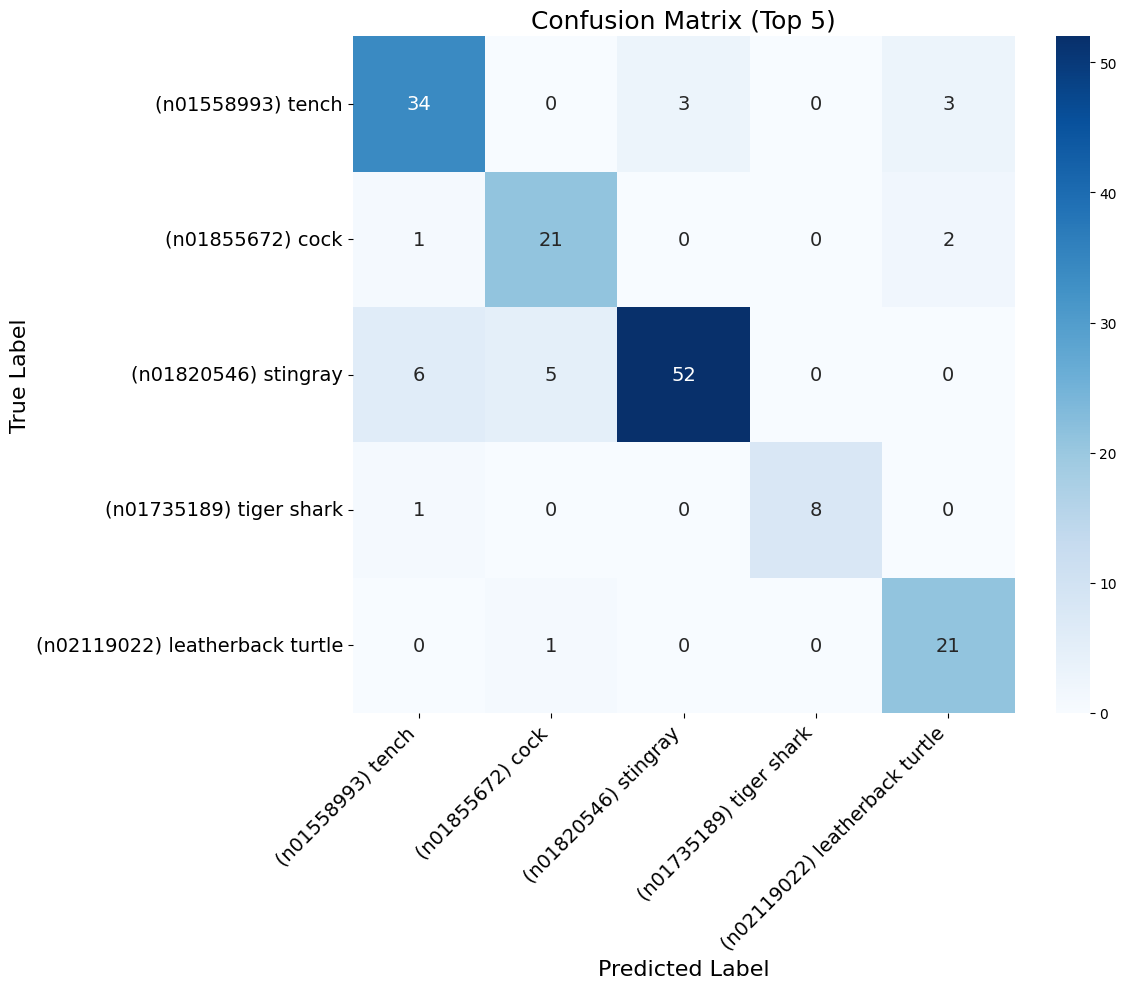

                           Class  Accuracy
9   (n02701002) alligator lizard  0.857143
10   (n03584829) boa constrictor  0.666667
7       (n02231487) banded gecko  0.639344
11          (n03837869) scorpion  0.600000
2           (n01820546) stingray  0.541667
13              (n04099969) tick  0.478261
8      (n02259212) common iguana  0.475000
12       (n04067472) wolf spider  0.384615
0              (n01558993) tench  0.340000
14            (n07831146) toucan  0.333333


In [31]:
import urllib.request

# Ambil label unik (indeks kelas) dari realtestloader.dataset.samples (list of (path, label))
filtered_samples = realtestloader.dataset.samples
unique_labels = sorted(set(label for _, label in filtered_samples))

# Ambil class_id (misal 'n01558993') dari trainset.classes berdasarkan label unik (indeks)
filtered_class_ids = [trainset.classes[label] for label in unique_labels]

# Download nama kelas ImageNet 1000 kelas yang umum (urutan sesuai index)
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = urllib.request.urlopen(url)
imagenet_labels = [line.decode('utf-8').strip() for line in response.readlines()]

# Mapping class_id ke nama deskriptif menggunakan trainset.class_to_idx dan imagenet_labels
# trainset.class_to_idx: {class_id: idx}
id_to_name = {}
for class_id, idx in trainset.class_to_idx.items():
    if idx < len(imagenet_labels):
        id_to_name[class_id] = imagenet_labels[idx]
    else:
        id_to_name[class_id] = "Unknown"

# Buat list kelas dengan format "(class_id) deskripsi"
filtered_class_names = [f"({class_id}) {id_to_name.get(class_id, 'Unknown')}" for class_id in filtered_class_ids]

print(filtered_class_names[:10])  # Contoh 10 kelas pertama

# Set num_classes = jumlah kelas yang muncul di realtestloader
num_classes = len(unique_labels)

# NOTE: Jika y_true dan y_pred adalah label indeks global (0 sampai total kelas trainset),
#       harus di-mapping ke indeks lokal unique_labels untuk cocok dengan filtered_class_names.

# Buat mapping label global ke label lokal (index di unique_labels)
label_map = {label: idx for idx, label in enumerate(unique_labels)}

def remap_labels(labels):
    remapped = []
    for l in labels:
        if l in label_map:
            remapped.append(label_map[l])
        else:
            # Misal: skip label atau bisa beri label -1 (tidak valid)
            # Atau kalau mau, print warning
            # print(f"Warning: label {l} not in filtered classes, skipping.")
            remapped.append(-1)
    return remapped

# Evaluasi
y_true_global, y_pred_global = evaluate_metrics(net, realtestloader, device, num_classes=len(trainset.classes))

# Remap y_true dan y_pred ke label lokal sesuai filtered_class_names
y_true = remap_labels(y_true_global)
y_pred = remap_labels(y_pred_global)

# Plot confusion matrix subset pakai kelas yang sudah readable
plot_confusion_subset(y_true, y_pred, class_names=filtered_class_names, top_n=5)

# Per-class accuracy
acc_df = per_class_accuracy(y_true, y_pred, class_names=filtered_class_names)
print(acc_df.head(10))